
<div class="note">
    <p style="margin-top: 0; margin-bottom: 0;">
        <img style="margin-top: 0; margin-bottom: 0; height: 2em;" class="inline-block mr-2 no-fancybox"
            src="https://upload.wikimedia.org/wikipedia/commons/3/38/Jupyter_logo.svg" alt="">
        This page is based on a Jupyter notebook.
<a href="./confined_gas_compression.ipynb" download="confined_gas_compression.ipynb"><img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" src="https://img.shields.io/static/v1?label=Download:&message=confined_gas_compression.ipynb&color=blue" /></a>
<a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/TH2M/TH/idealGasLaw/confined_gas_compression.py"><img src="https://img.shields.io/static/v1?label=Source:&message=confined_gas_compression.py&color=brightgreen" class="no-fancybox"
        style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" /></a>
<a href="https://binder.opengeosys.org/v2/gh/bilke/binder-ogs-requirements/master?urlpath=git-pull%3Frepo=https://gitlab.opengeosys.org/ogs/ogs%26urlpath=lab/tree/ogs/Tests/Data/TH2M/TH/idealGasLaw/confined_gas_compression.py%26branch=master%26depth=1">
    <img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;"
        src="https://img.shields.io/static/v1?label=&message=Launch notebook&color=5c5c5c&logo=" />
</a></p></div>

|<div style="width:330px"><img src="https://www.ufz.de/static/custom/weblayout/DefaultInternetLayout/img/logos/ufz_transparent_de_blue.png" width="300"/></div>|<div style="width:330px"><img src="https://discourse.opengeosys.org/uploads/default/original/1X/a288c27cc8f73e6830ad98b8729637a260ce3490.png" width="300"/></div>|<div style="width:330px"><img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png" width="300"/></div>|
|---|---|--:|

# Confined compression of a cube

In this test, the thermodynamic relationships between gas pressure, temperature and density are tested.
For that, a cube-shaped domain consisting of an ideal gas is compressed by 50\% of its initial volume over a short period of time, starting from the top surface.
The boundaries of that domain are impermeable to fluid flow, therefore gas pressure and density must increase as a result of the decreasing volume.
Since energy flow across the boundaries is also prevented, this compression is an adiabatic change of state. No frictional losses are taken into account, so the process can be reversed at any time and the entropy in the overall system remains constant.

## Analytical solution

### Density evolution

The mass balance for such a system can be found by simplifying the mass balance (eq. 44 in Grunwald et al., 2022). With
$\phi=s_\mathrm{G}=\alpha_\mathrm{B}=1$ and $\mathrm{A}^\zeta_\alpha=\mathrm{J}^\zeta_\alpha=0$
one obtains
$$
0=\rho_\mathrm{GR}\mathrm{div}\left(\mathbf{u}_\mathrm{S}\right)'_\mathrm{S}+\left(\rho_\mathrm{GR}\right)'_\mathrm{S}
$$

With volume strain $e=\text{div}\left(\mathbf{u}_\text{S}\right)'_\text{S}$ we write
$$
\frac{1}{\rho_\text{GR}}\left(\rho_\text{GR}\right)'_\text{S}=-e,
$$
which can be integrated
$$
\int^{\rho_\text{GR}}_{\rho_{\text{GR},0}}\frac{1}{\rho_\text{GR}}\text{d}\,\rho_\text{GR}=-e
$$
so that we find
$$
\ln\left(\rho_\text{GR}\right) - \ln\left(\rho_{\text{GR},0}\right) = -e
$$
or
$$
\rho_\text{GR}=\rho_{\text{GR},0}\exp\left(-e\right).
$$

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import ogstools as ot
import vtuIO

In [2]:
# time runs from 0 to 10 in 11 steps
t = np.linspace(0, 10, 11)

# volume strain is a function of time
e = -t / 100

# initial state
p_0 = 1e6
T_0 = 270
R = 8.3144621
M = 0.01
c_p = 1000

c_v = c_p - R / M
rho_0 = p_0 * M / R / T_0
kappa = c_p / c_v

# density
rho_GR = rho_0 * np.exp(-e)

### Gas pressure evolution

The evolution of gas pressure can be found from energy balance equation (eq. 51 in the paper):
Starting from
$$
\left(\Sigma_\alpha\rho_\alpha u_\alpha\right)'_\text{S}
+\left(\Sigma_\alpha\rho_\alpha h_\alpha\right)\text{div}\left(\mathbf{u}_\text{S}\right)'_\text{S}
=0,
$$
with $u_\text{S}=h_\text{S}$ and $u_\text{G}=h_\text{G}-\frac{p_\text{GR}}{\rho_\text{GR}}$ and with $h_\alpha=c_{p,\alpha}T$. Considering that $\phi_\alpha=\text{const}$ and $c_{p,\text{S}}=0$, we find
$$
\left(\rho_\text{GR}\right)'_\text{S}\left(c_{p,\text{G}}T-p_\text{GR}\rho_\text{GR}^{-1}\right)
+
\rho_\text{GR}\left(c_{p,\text{G}}T-p_\text{GR}\rho_\text{GR}^{-1}\right)'_\text{S}
+
\rho_\text{GR}c_{p,\text{G}}Te=0.
$$
Assuming ideal gas behaviour, we can write $\frac{p_\text{GR}}{\rho_\text{GR}}=\frac{M}{RT}$ and find
$$
\left(\rho_\text{GR}\right)'_\text{S}c_{v,\text{G}}T
+
\rho_\text{GR}\left(c_{v,\text{G}}T\right)'_\text{S}
+
\rho_\text{GR}c_{p,\text{G}}Te=0.
$$
With $c_{v,\text{G}}=\text{const}$ it follows
$$
\frac{\rho_\text{GR}}{p_\text{GR}}\left(p_\text{GR}\right)'_\text{S}c_{v,\text{G}}T
+
\rho_\text{GR}c_{p,\text{G}}Te=0.
$$
Density and temperature cancel out so the final equation can be written as
$$
\frac{1}{p_\text{GR}}\left(p_\text{GR}\right)'_\text{S}
=-\kappa e
$$
with the adiabatic index $\kappa = \frac{c_v}{c_p}$. The equation can be integrated to find the solution for the pressure evolution
$$
p_\text{GR}=p_{\text{GR},0}\exp\left(-\kappa e\right)
$$

In [3]:
# gas pressure
p_GR = p_0 * np.exp(-kappa * e)

### Temperature evolution

The temperature evolution follows _Poissons_ equations for isentropic processes
$$
T=T_0\left(\frac{p_\text{GR}}{p_{\text{GR},0}}\right)^{\frac{\kappa-1}{\kappa}}.
$$

In [4]:
# temperature
T = p_GR * M / R / rho_GR

## Numerical solution

In [5]:
out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
if not out_dir.exists():
    out_dir.mkdir(parents=True)

In [6]:
# run OGS
cube_compression = ot.Project(
    input_file="compression_gas.prj", output_file="compression_gas.prj"
)
cube_compression.run_model(logfile=f"{out_dir}/out.txt", args=f"-o {out_dir}")

OGS finished with project file compression_gas.prj.
Execution took 0.30058741569519043 s
Project file written to output.


In [7]:
# read PVD file
pvdfile = vtuIO.PVDIO(f"{out_dir}/result_compression_gas.pvd", dim=2)
# get all timesteps
time = pvdfile.timesteps

In [8]:
# read pressure, temperature and density from pvd result file
# at point
point = {"pt0": (0.0, 1.0, 0.0)}

pressure = pvdfile.read_time_series("gas_pressure_interpolated", point)
p_GR_num = pressure["pt0"]

temperature = pvdfile.read_time_series("temperature_interpolated", point)
T_num = temperature["pt0"]

density = pvdfile.read_time_series("gas_density", point)
rho_GR_num = density["pt0"]

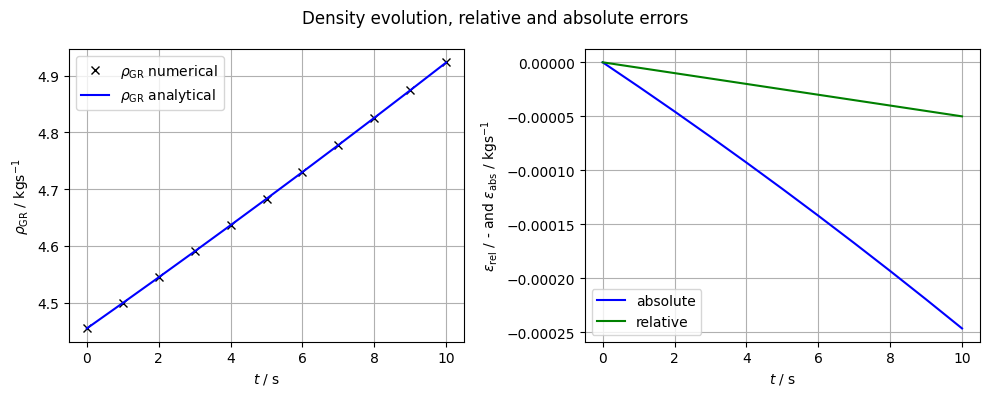

In [9]:
plt.rcParams["figure.figsize"] = (10, 4)
fig1, (ax1, ax2) = plt.subplots(1, 2)
fig1.suptitle(r"Density evolution, relative and absolute errors")

ax1.plot(time, rho_GR_num, "kx", label=r"$\rho_\mathrm{GR}$ numerical")
ax1.plot(t, rho_GR, "b", label=r"$\rho_\mathrm{GR}$ analytical")
ax1.set_xlabel(r"$t$ / s")
ax1.set_ylabel(r"$\rho_\mathrm{GR}$ / kgs$^{-1}$")
ax1.legend()
ax1.grid(True)
# ax1.set_xlim(0,1)
# ax1.set_ylim(0,1)

err_rho_abs = rho_GR - rho_GR_num
err_rho_rel = err_rho_abs / rho_GR

ax2.plot(t, err_rho_abs, "b", label=r"absolute")
ax2.plot(t, err_rho_rel, "g", label=r"relative")

ax2.set_xlabel(r"$t$ / s")
ax2.set_ylabel(r"$\epsilon_\mathrm{rel}$ / - and $\epsilon_\mathrm{abs}$ / kgs$^{-1}$")
ax2.legend()
ax2.grid(True)
# ax2.set_xlim(0,1)
# ax2.set_ylim(-0.001,0.02)

fig1.tight_layout()
plt.show()

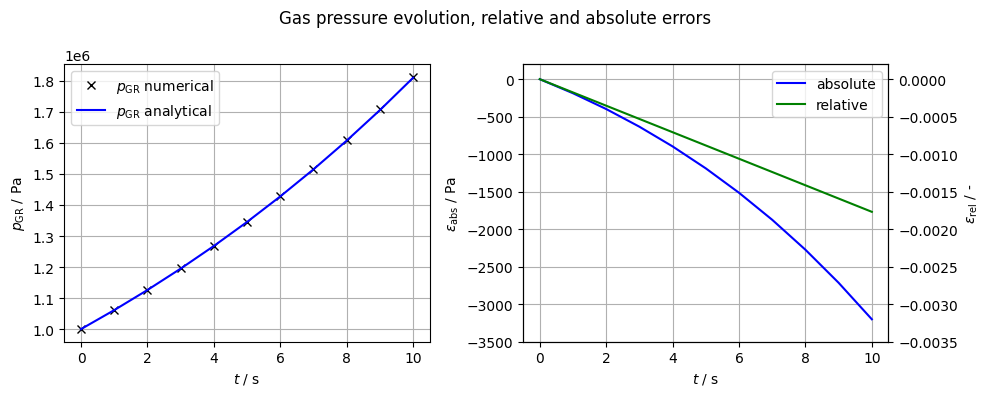

In [10]:
plt.rcParams["figure.figsize"] = (10, 4)
fig1, (ax1, ax2) = plt.subplots(1, 2)
fig1.suptitle(r"Gas pressure evolution, relative and absolute errors")


ax1.plot(time, p_GR_num, "kx", label=r"$p_\mathrm{GR}$ numerical")
ax1.plot(t, p_GR, "b", label=r"$p_\mathrm{GR}$ analytical")
ax1.set_xlabel(r"$t$ / s")
ax1.set_ylabel(r"$p_\mathrm{GR}$ / Pa")
ax1.legend()
ax1.grid(True)
# ax1.set_xlim(0,1)
# ax1.set_ylim(0,1)

err_p_abs = p_GR - p_GR_num
err_p_rel = err_p_abs / p_GR

lns1 = ax2.plot(t, err_p_abs, "b", label=r"absolute")
ax3 = ax2.twinx()
lns2 = ax3.plot(t, err_p_rel, "g", label=r"relative")

# added these three lines
lns = lns1 + lns2
labs = [label.get_label() for label in lns]
ax2.legend(lns, labs, loc=0)
ax2.grid(True)

ax2.set_xlabel(r"$t$ / s")
ax2.set_ylabel(r"$\epsilon_\mathrm{abs}$ / Pa")
ax3.set_ylabel(r"$\epsilon_\mathrm{rel}$ / -")

# ax2.set_xlim(0,1)
ax2.set_ylim(-3500, 200)
ax3.set_ylim(-0.0035, 0.0002)

fig1.tight_layout()
plt.show()

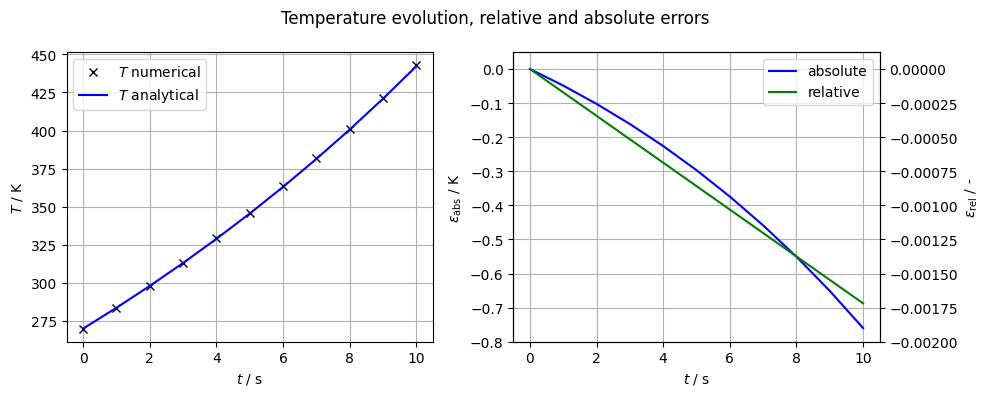

In [11]:
plt.rcParams["figure.figsize"] = (10, 4)
fig1, (ax1, ax2) = plt.subplots(1, 2)
fig1.suptitle(r"Temperature evolution, relative and absolute errors")


ax1.plot(time, T_num, "kx", label=r"$T$ numerical")
ax1.plot(t, T, "b", label=r"$T$ analytical")
ax1.set_xlabel(r"$t$ / s")
ax1.set_ylabel(r"$T$ / K")
ax1.legend()
ax1.grid(True)
# ax1.set_xlim(0,1)
# ax1.set_ylim(0,1)

err_T_abs = T - T_num
err_T_rel = err_T_abs / T


lns1 = ax2.plot(t, err_T_abs, "b", label=r"absolute")
ax3 = ax2.twinx()
lns2 = ax3.plot(t, err_T_rel, "g", label=r"relative")

# added these three lines
lns = lns1 + lns2
labs = [label.get_label() for label in lns]
ax2.legend(lns, labs, loc=0)
ax2.grid(True)

ax2.set_xlabel(r"$t$ / s")
ax2.set_ylabel(r"$\epsilon_\mathrm{abs}$ / K")
ax3.set_ylabel(r"$\epsilon_\mathrm{rel}$ / -")

# ax2.set_xlim(0,1)
ax2.set_ylim(-0.8, 0.05)
ax3.set_ylim(-0.002, 0.000125)

fig1.tight_layout()
plt.show()